Attempt of visualizing the way neural networks work

Based on the idea of networks as "rotating" data, through matrix multiplication, and "squashing", through nonlinear activation funcitons.

In [2]:
# In case of Pylance import error, make sure correct interpretor is selected (JL-ML)
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers, losses
import math

In [3]:
# Generate spiral, non linearly separable classes 

N = 1000 # samples per class
D = 2 # data dimensions
C = 3 # classes
H = 2 # hidden units

X = np.zeros([N * C, D]) # data matrix / tensor
y = np.zeros(N * C, dtype='long') # class labels

for c in range(C):
    index = 0
    # generate spiral data for each class
    t = np.linspace(0, 1, N) # parameter values

    inner_var = np.linspace(
        (2 * math.pi / C) * (c),
        (2 * math.pi / C) * (2 + c),
        N
    ) + tf.random.normal((N,)) * 0.2

    for ix in range(N * c, N * (c + 1)):
        X[ix] = t[index] * np.array([math.sin(inner_var[index]), math.cos(inner_var[index])], dtype='float')
        y[ix] = c
        index += 1


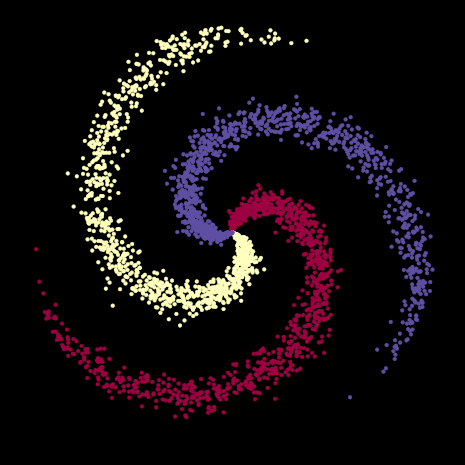

In [66]:
# Set plot colors
figsize = (10, 10)
dpi = 60

plt.style.use(['dark_background', 'bmh'])
plt.rc('axes', facecolor='k')
plt.rc('figure', facecolor='k')
plt.rc('figure', figsize=figsize, dpi=dpi)

def plot_data(X, y=None):
    # TODO: add 3d plot option?
    
    # fig, ax = plt.subplots(figsize=(17, 17), dpi=30)
    plt.axis('square')
    plt.axis(np.array((-1.1, 1.1, -1.1, 1.1)))
    plt.axis('off')
    
    if y is not None:
        plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap=plt.cm.Spectral)
    else:
        plt.scatter(X[:,0], X[:,1], s=20, cmap=plt.cm.Spectral)
    

plot_data(X, y)

[array([[-0.083408 , -0.5151399],
       [-1.1578248, -1.0811057]], dtype=float32), array([0., 0.], dtype=float32)]
det(W) = -0.50626886


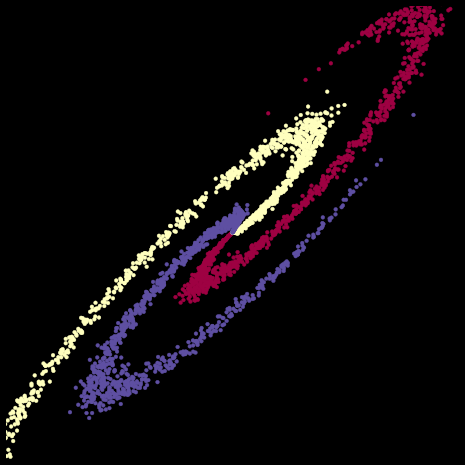

In [5]:
# simple linear dense layer
# applies an affine transformation with
# weight matrix and biases

model = keras.Sequential([
    keras.Input(shape=(D,)),
    layers.Dense(H, activation='linear'),
])

for layer in model.layers:
    w = layer.get_weights()
    print(w)
    print('det(W) =', np.linalg.det(w[0]))

plot_data(model(X), y)

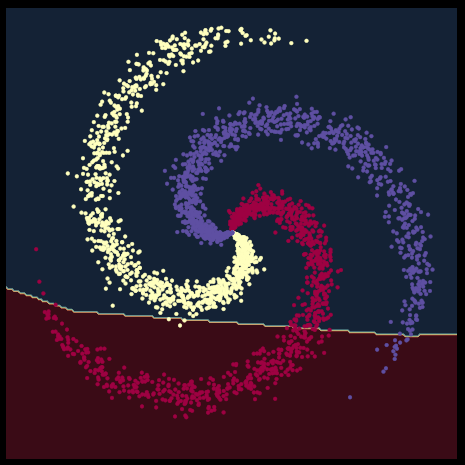

In [18]:
def plot_model(model, x, y):
    mesh = np.arange(-1.1, 1.1, 0.01)
    xx, yy = np.meshgrid(mesh, mesh)
    # reshape(-1): into 1-d array, -1 means numpy figures out shape
    data_stack = np.vstack((xx.reshape(-1), yy.reshape(-1))).T
    data = tf.convert_to_tensor(data_stack)
    Z = model(data)
    Z = np.argmax(Z, axis=1).reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3)
    plot_data(x, y)
    
plot_model(model, X, y)

[array([[-1.0941643 ,  0.724486  ],
       [ 0.9587916 ,  0.75732255]], dtype=float32), array([0., 0.], dtype=float32)]
det(W) = -1.5232663


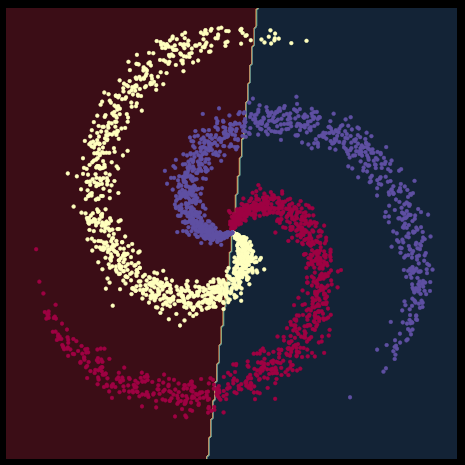

In [7]:
# with nonlinear activation function

model = keras.Sequential([
    keras.Input(shape=(D,)),
    layers.Dense(H, activation='tanh'),
])

for layer in model.layers:
    w = layer.get_weights()
    print(w)
    print('det(W) =', np.linalg.det(w[0]))

plot_model(model, X, y)

In [8]:
# How does it look for a trained model?

model = keras.Sequential([
    keras.Input(shape=(D,)),
    layers.Dense(D, activation='relu'),
    layers.Dense(D, activation='relu'),
    layers.Dense(C, activation='linear')
])


In [9]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices((X, y))    
dataset = dataset.batch(32)

# list(dataset.as_numpy_iterator())

In [10]:
# Define loss & gradient step functions

# Sparse uses regular class indices instead of one hot
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

def loss(model, feats, labels):
    y_ = model(feats)
    return loss_object(y_true=labels, y_pred=y_)

def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

features, labels = next(iter(dataset))
print("loss: {}".format(loss(model, features, labels)))


loss: 1.0986123085021973


In [11]:
n_epochs = 221

train_loss_results = []
train_accuracy_results = []

for epoch in range(n_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

    # training loop
    for feats, labels in dataset:
        loss_value, grads = grad(model, feats, labels)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Record loss & acc for printing
        epoch_loss_avg.update_state(loss_value)
        epoch_accuracy.update_state(labels, model(feats))
     
    # Record loss & acc for plotting
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())

    if epoch % 20 == 0:
        print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(
            epoch, epoch_loss_avg.result(), epoch_accuracy.result()))

Epoch 000: Loss: 1.039, Accuracy: 45.900%
Epoch 020: Loss: 0.969, Accuracy: 47.867%
Epoch 040: Loss: 0.950, Accuracy: 48.133%
Epoch 060: Loss: 0.947, Accuracy: 47.567%
Epoch 080: Loss: 0.946, Accuracy: 48.567%
Epoch 100: Loss: 0.945, Accuracy: 48.500%
Epoch 120: Loss: 0.945, Accuracy: 48.867%
Epoch 140: Loss: 0.945, Accuracy: 47.967%
Epoch 160: Loss: 0.945, Accuracy: 47.933%
Epoch 180: Loss: 0.945, Accuracy: 48.900%
Epoch 200: Loss: 0.945, Accuracy: 48.867%


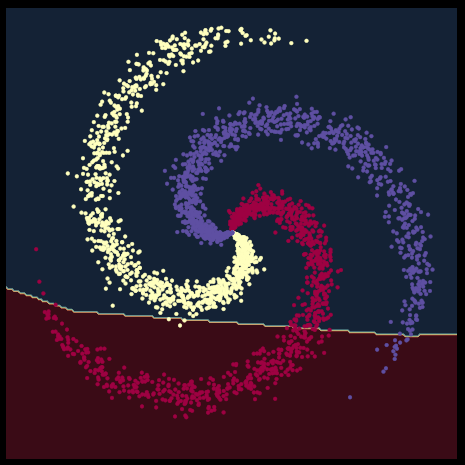

In [12]:
plot_model(model, X,  y)

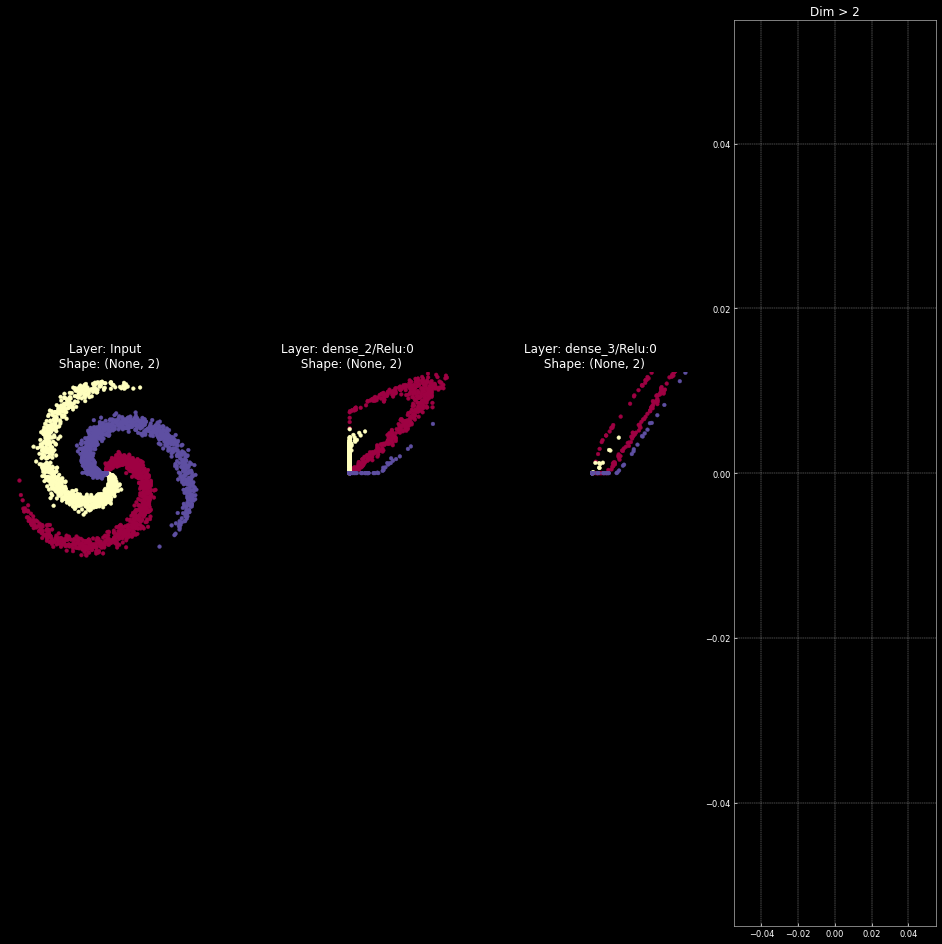

In [67]:
# Show output after each layer

from keras import backend

layers = []
names = []
# Add input as function
layers.append(backend.function([model.layers[0].input], [model.layers[0].input]))
names.append(('Input', model.layers[0].input.shape))

# Store all layer output functions
for layer in model.layers:
    layers.append(backend.function([model.layers[0].input], [layer.output]))
    names.append((layer.output.name, layer.output.shape))

nbr_layers = len(layers)
f, axs = plt.subplots(1, nbr_layers, figsize=(20, 20))
for i, f in enumerate(layers):
    plt.subplot(1, nbr_layers, i + 1)
    plt.title('Layer: {} \n Shape: {}'.format(names[i][0], names[i][1]))
    plot_data(f(X)[0], y)
